![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 07 - PyTorch</center>
### <center> Schdeulers</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/07_PyTorch2/MainPyTorchSchdulers.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib
import torch

matplotlib.rc('font', **{'size' : 16})

#-- Fix seed (for presentation sake)
torch.manual_seed(0)
np.random.seed   (0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/07_PyTorch2/DeepLearningFramework ./DeepLearningFramework

### Download CIFAR-10 dataset:

In [5]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())
lClasses  = oTrainSet.classes

oTrainSet.data.shape, oTrainSet[0][0].shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), torch.Size([3, 32, 32]))

#### Compute mean and variance:

In [6]:
vMean = oTrainSet.data.mean((0,1,2)) / 255
vStd  = oTrainSet.data.std ((0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


#### Set datasets with normalization:

In [7]:
oTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(vMean, vStd)
])

oTrainSet.transform = oTransform
oTestSet .transform = oTransform

#### Create data loaders:

In [8]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

#### Define the model (2D CNN):

In [9]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchsummary

def WeightInit(oModule):
        if isinstance(oModule, nn.Conv2d):
            nn.init.kaiming_normal_(oModule.weight.data)

#-- Model:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv2d(3,   30,  3, bias=False), nn.BatchNorm2d(30),                   nn.ReLU(),
        nn.Conv2d(30,  100, 3, bias=False), nn.BatchNorm2d(100), nn.MaxPool2d(2), nn.ReLU(),
        nn.Conv2d(100, 200, 3, bias=False), nn.BatchNorm2d(200),                  nn.ReLU(),
        nn.Conv2d(200, 200, 3, bias=False), nn.BatchNorm2d(200),                  nn.ReLU(),
        nn.Conv2d(200, 200, 3, bias=False), nn.BatchNorm2d(200),                  nn.ReLU(),
                
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(200, 10)
    )
    
    oModel.apply(WeightInit)
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchsummary.summary(GetModel(), (3, 32, 32), device='cpu');

Layer (type:depth-idx)                   Output Shape              Param #
├─Identity: 1-1                          [-1, 3, 32, 32]           --
├─Conv2d: 1-2                            [-1, 30, 30, 30]          810
├─BatchNorm2d: 1-3                       [-1, 30, 30, 30]          60
├─ReLU: 1-4                              [-1, 30, 30, 30]          --
├─Conv2d: 1-5                            [-1, 100, 28, 28]         27,000
├─BatchNorm2d: 1-6                       [-1, 100, 28, 28]         200
├─MaxPool2d: 1-7                         [-1, 100, 14, 14]         --
├─ReLU: 1-8                              [-1, 100, 14, 14]         --
├─Conv2d: 1-9                            [-1, 200, 12, 12]         180,000
├─BatchNorm2d: 1-10                      [-1, 200, 12, 12]         400
├─ReLU: 1-11                             [-1, 200, 12, 12]         --
├─Conv2d: 1-12                           [-1, 200, 10, 10]         360,000
├─BatchNorm2d: 1-13                      [-1, 200, 10, 10]         4

### Add scheduler to the training loop:

In [10]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    #===================================#
    vLR         = np.full(nIter, np.nan)
    #===================================#
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU
    

    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)

        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mZ   = oModel(mX)
            loss = Loss(mZ, vY)
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mZ   = oModel(mX)
                loss = Loss(mZ, vY)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            #============================================#
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate
            #============================================#

        Nb           = vY.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        epochMetric += Nb * Metric(mZ, vY)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [11]:
import time
from DeepLearningFramework.Metric import Accuracy

def TrainClassficationModel(oModel, oTrainData, oValData, Loss, nEpochs, oOptim, oScheduler=None):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainAcc  = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValAcc    = np.full(nEpochs, np.nan)
    vLR        = np.full(0,       np.nan)
    bestAcc    = 0

    for epoch in range(nEpochs):
        startTime                 = time.time()
        #================================================================================================================#
        trainLoss, trainAcc, vLRi = Epoch(oModel, oTrainData, Loss, Accuracy, oOptim, oScheduler, bTrain=True ) #-- train
        #================================================================================================================#
        valLoss,   valAcc,   _    = Epoch(oModel, oValData,   Loss, Accuracy,                     bTrain=False) #-- validate
        epochTime                 = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',   end='')
        print(' | Train loss: '     f'{trainLoss:.5f}' ,   end='')
        print(' | Val loss: '       f'{valLoss  :.5f}' ,   end='')
        print(' | Train Accuracy: ' f'{trainAcc :2.4f}',   end='')
        print(' | Val Accuracy: '   f'{valAcc   :2.4f}',   end='')
        print(' | epoch time: '     f'{epochTime:6.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainAcc [epoch] = trainAcc
        vValLoss  [epoch] = valLoss
        vValAcc   [epoch] = valAcc
        #==============================================#
        vLR               = np.concatenate([vLR, vLRi])
        #==============================================#

        #-- Save best model (early stopping):
        if bestAcc < valAcc:
            bestAcc = valAcc
            try:
                torch.save(oModel.state_dict(), 'BestModel.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load('BestModel.pt'))

    return vTrainLoss, vTrainAcc, vValLoss, vValAcc, vLR

#### Device, loss, and epochs:

In [12]:
DEVICE  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss    = nn.CrossEntropyLoss()
nEpochs = 30
nIter   = nEpochs * len(oTrainDL)
nIter

11730

### Define schedulers:

![](https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/07_PyTorch2/Schedulers.PNG?raw=true)


In [13]:
from torch.optim import lr_scheduler

lScheduler   = []
lScheduler  += [('Exp',      lr_scheduler.ExponentialLR,     {'gamma'  :0.9995})]
lScheduler  += [('Cos',      lr_scheduler.CosineAnnealingLR, {'T_max'  :nIter} )]
lScheduler  += [('Cyclic',   lr_scheduler.CyclicLR,          {'base_lr':1e-4, 'max_lr':1e-2, 'step_size_up':nIter//6, 'step_size_down':nIter//6, 'mode':'triangular2', 'cycle_momentum':False})]
lScheduler  += [('OneCycle', lr_scheduler.OneCycleLR,        {'max_lr' :1e-2, 'total_steps':nIter})]

#### Train with different schedulers:

In [14]:
dHistory = {}

for (name, Scheduler, dArgs) in lScheduler:
    print('=================================================================================================')
    print(name)
    print('=================================================================================================')
    
    oModel         = GetModel().to(DEVICE)
    oOptim         = optim.AdamW(oModel.parameters(), lr=1e-2, betas=(0.9, 0.99), weight_decay=1e-4)
    oScheduler     = Scheduler(oOptim, **dArgs)
    dHistory[name] = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler=oScheduler);

Exp
Epoch 000: | Train loss: 1.28539 | Val loss: 1.27294 | Train Accuracy: 0.5313 | Val Accuracy: 0.5685 | epoch time: 25.629 | <-- Checkpoint!
Epoch 001: | Train loss: 0.80373 | Val loss: 0.75298 | Train Accuracy: 0.7157 | Val Accuracy: 0.7438 | epoch time: 24.405 | <-- Checkpoint!
Epoch 002: | Train loss: 0.60556 | Val loss: 0.66571 | Train Accuracy: 0.7883 | Val Accuracy: 0.7680 | epoch time: 24.429 | <-- Checkpoint!
Epoch 003: | Train loss: 0.48229 | Val loss: 0.56316 | Train Accuracy: 0.8327 | Val Accuracy: 0.8053 | epoch time: 24.378 | <-- Checkpoint!
Epoch 004: | Train loss: 0.38855 | Val loss: 0.48811 | Train Accuracy: 0.8652 | Val Accuracy: 0.8343 | epoch time: 24.628 | <-- Checkpoint!
Epoch 005: | Train loss: 0.31837 | Val loss: 0.48620 | Train Accuracy: 0.8905 | Val Accuracy: 0.8388 | epoch time: 24.672 | <-- Checkpoint!
Epoch 006: | Train loss: 0.26668 | Val loss: 0.48086 | Train Accuracy: 0.9097 | Val Accuracy: 0.8394 | epoch time: 24.665 | <-- Checkpoint!
Epoch 007: | Tra

Epoch 029: | Train loss: 0.00018 | Val loss: 0.85924 | Train Accuracy: 1.0000 | Val Accuracy: 0.8683 | epoch time: 24.429 |
Cyclic
Epoch 000: | Train loss: 1.32762 | Val loss: 1.14191 | Train Accuracy: 0.5256 | Val Accuracy: 0.5941 | epoch time: 24.842 | <-- Checkpoint!
Epoch 001: | Train loss: 0.89743 | Val loss: 1.14145 | Train Accuracy: 0.6838 | Val Accuracy: 0.6223 | epoch time: 24.966 | <-- Checkpoint!
Epoch 002: | Train loss: 0.73692 | Val loss: 1.15300 | Train Accuracy: 0.7413 | Val Accuracy: 0.6152 | epoch time: 24.491 |
Epoch 003: | Train loss: 0.63734 | Val loss: 1.01412 | Train Accuracy: 0.7787 | Val Accuracy: 0.6729 | epoch time: 24.904 | <-- Checkpoint!
Epoch 004: | Train loss: 0.55659 | Val loss: 0.68251 | Train Accuracy: 0.8081 | Val Accuracy: 0.7722 | epoch time: 24.412 | <-- Checkpoint!
Epoch 005: | Train loss: 0.46321 | Val loss: 0.67763 | Train Accuracy: 0.8389 | Val Accuracy: 0.7844 | epoch time: 25.821 | <-- Checkpoint!
Epoch 006: | Train loss: 0.33441 | Val loss: 

Epoch 028: | Train loss: 0.00027 | Val loss: 0.78051 | Train Accuracy: 1.0000 | Val Accuracy: 0.8755 | epoch time: 26.021 | <-- Checkpoint!
Epoch 029: | Train loss: 0.00021 | Val loss: 0.79050 | Train Accuracy: 1.0000 | Val Accuracy: 0.8741 | epoch time: 25.541 |


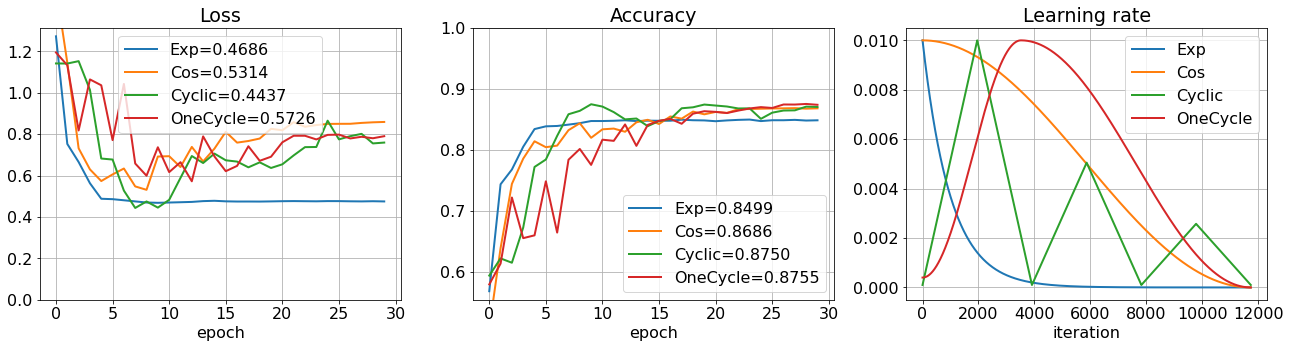

In [21]:
def PlotHistory(dHistory):

    _, vAx = plt.subplots(1, 3, figsize=(22, 5))

    for key in dHistory:
        
        _, _, vValLoss, vValAcc, vLR = dHistory[key]
        vAx[0].plot      (vValLoss, lw=2, label=f'{key}={vValLoss.min():.4f}')
        vAx[0].set_title ('Loss')
        vAx[0].set_xlabel('epoch')
        vAx[0].set_ylim  (bottom=0)
        vAx[0].legend    ()
        vAx[0].grid      (True)

        vAx[1].plot      (vValAcc, lw=2, label=f'{key}={vValAcc.max():.4f}')
        vAx[1].set_title ('Accuracy')
        vAx[1].set_xlabel('epoch')
        vAx[1].set_ylim  (top=1)
        vAx[1].legend    ()
        vAx[1].grid      (True)
        
        vAx[2].plot      (vLR, lw=2, label=key)
        vAx[2].set_title ('Learning rate')
        vAx[2].set_xlabel('iteration')
        vAx[2].legend    ()
        vAx[2].grid      (True)
    
PlotHistory (dHistory)
plt.show    ()